<a href="https://colab.research.google.com/github/shizacharania/Brain-Tumour-Classification/blob/main/Brain_Tumour_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# upload the generated api token in .json format from local system
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shizacharania","key":"f4d4c61a9252e57ae14d3185e707df48"}'}

In [ ]:
# make a kaggle directory in my files
!mkdir ~/.kaggle

In [ ]:
# put the kaggle.json file in that directory
!cp kaggle.json ~/.kaggle/

In [ ]:
# grant permission for the .json file to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# list available datsets to ensure that the API worked and kaggle's linked
!kaggle datasets list

ref                                                         title                                               size  lastUpdated          downloadCount  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
nkitgupta/jigsaw-regression-based-data                      Jigsaw Regression Based Data                         3GB  2022-01-10 06:29:59            676  
yamqwe/omicron-covid19-variant-daily-cases                  Omicron daily cases by country (COVID-19 variant)  432KB  2022-01-30 09:11:54          12099  
prasertk/netflix-subscription-price-in-different-countries  Netflix subscription fee in different countries      3KB  2022-01-15 07:06:09           1691  
yasserh/wine-quality-dataset                                Wine Quality Dataset                                21KB  2022-01-15 19:15:11           1508  
iamsouravbanerjee/analytics-industry-salaries-2022-india    Data Profe

In [ ]:
# download the mri segmentation datset with its api command
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 93% 81.0M/86.8M [00:00<00:00, 109MB/s] 
100% 86.8M/86.8M [00:00<00:00, 116MB/s]


In [ ]:
!unzip /content/brain-tumor-classification-mri.zip

In [ ]:
import glob
import cv2
import os


tr_gt = glob.glob("/content/Training/glioma_tumor/*") # training images glioma tumor
tr_mt = glob.glob("/content/Training/meningioma_tumor/*")
tr_none = glob.glob("/content/Training/no_tumor/*")
tr_pt = glob.glob("/content/Training/pituitary_tumor/*")

te_gt = glob.glob("/content/Testing/glioma_tumor/*") # training images glioma tumor
te_mt = glob.glob("/content/Testing/meningioma_tumor/*")
te_none = glob.glob("/content/Testing/no_tumor/*")
te_pt = glob.glob("/content/Testing/pituitary_tumor/*")

training_files = []
testing_files = []

def appendimages(list_files, g_files, m_files, none_files, p_files):
  for gt in g_files:
    list_files.append(gt)
  for mt in m_files:
    list_files.append(mt)
  for nonet in none_files:
    list_files.append(nonet)
  for pt in p_files:
    list_files.append(pt)

appendimages(training_files, tr_gt, tr_mt, tr_none, tr_pt)
appendimages(testing_files, te_gt, te_mt, te_none, te_pt)

total_files = []
for one_file1 in training_files:
  total_files.append(one_file1)
for one_file2 in testing_files:
  total_files.append(one_file2)

print(len(training_files), len(testing_files))
print(len(total_files))

2870 394
3264


926 937 500 901


<BarContainer object of 4 artists>

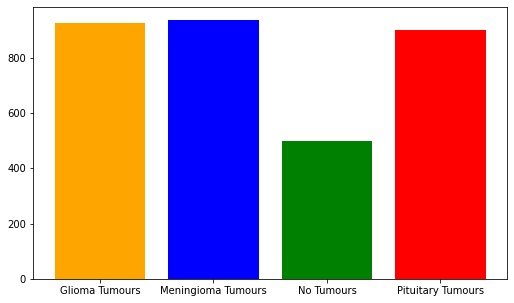

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

total_gt = len(tr_gt) + len(te_gt)
total_mt = len(tr_mt) + len(te_mt)
total_none = len(tr_none) + len(te_none)
total_pt = len(tr_pt) + len(te_pt)

print(total_gt, total_mt, total_none, total_pt)
total_images = total_gt + total_mt + total_none + total_pt

fig = plt.figure(figsize = (8.5, 5))

plt.bar(["Glioma Tumours", "Meningioma Tumours", "No Tumours", "Pituitary Tumours"], [total_gt, total_mt, total_none, total_pt], color=["orange", "blue", "green", "red"])

In [ ]:
file_shapes = 0

for each_file in total_files:
  a_file = cv2.imread(each_file)
  shp = a_file.shape[0]
  file_shapes += shp

mean_file_size = file_shapes/len(total_files)
print(mean_file_size)

469.780943627451


In [ ]:
import torch

# find mean and standard deviation
num_pixels = total_images*mean_file_size*mean_file_size

total_sum = 0
for each_file in total_files:
  a_file = cv2.imread(each_file)
  a_file = cv2.resize(a_file, (int(mean_file_size), int(mean_file_size)))
  a_tensor = torch.from_numpy(a_file)
  total_sum += a_tensor[0].sum() # there is a [0] because you only need one channel's sum, not all 3
  mean = total_sum/num_pixels

# std calculated with formula
sum_squared_error = 0
for each_file in total_files:
  a_file = cv2.imread(each_file)
  a_file = cv2.resize(a_file, (int(mean_file_size), int(mean_file_size)))
  a_tensor = torch.from_numpy(a_file)
  sum_squared_error += ((a_tensor[0]-mean)**2).sum()
  std = (sum_squared_error/num_pixels)**0.5

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor(0.0421)
Standard Deviation: tensor(2.1139)


In [ ]:
from torchvision.transforms.transforms import RandomRotation
import torch
import torchvision
import torchvision.transforms as transforms

tr_image_data = []
teimage_data = []
tr_label_data = []
telabel_data = []

def loading_data(lst, datalist, labellist, yn_transforms):
  count = 0
  for d in lst:
    if "glioma_tumor" in d:
      labellist.append(int(0))
    elif "meningioma_tumor"in d:
      labellist.append(int(1))
    elif "no_tumor"in d:
      labellist.append(int(2))
    elif "pituitary_tumor"in d:
      labellist.append(int(3))

    img = cv2.imread(str(d))
    img = cv2.resize(img, (64,64))

    # transforms
    if yn_transforms == True: # training
      transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.RandomHorizontalFlip(p=0.5), 
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.Normalize(mean, std)])  
      img = transform(img)

      if count % 10 == 0:
        another_transform = transforms.RandomRotation(degrees=(90))
        img = another_transform(img)

      datalist.append(img)

    elif yn_transforms == False: # testing
      transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean, std)]) 
      img = transform(img)
      datalist.append(img)
    
    count += 1


In [ ]:
loading_data(training_files, tr_image_data, tr_label_data ,True)
print(tr_image_data[0].shape)

torch.Size([3, 64, 64])


In [ ]:
loading_data(testing_files, teimage_data, telabel_data, False)
print(teimage_data[0].shape) 

torch.Size([3, 64, 64])


In [ ]:
print(len(tr_image_data), len(tr_label_data))
print(len(teimage_data), len(telabel_data))

2870 2870
394 394


In [ ]:
len_trdataset = int(len(tr_image_data)*0.8) # 2296, but we use 2272 so it can divide evenly into the batch size
trimage_data = tr_image_data[:2272]
trlabel_data = tr_label_data[:2272]

valid_len = (2870-2272) # 598 -> need 576
vimage_data = tr_image_data[2294:] 
vlabel_data = tr_label_data[2294:]

te_len = 0
teimage_data = teimage_data[:384] 
telabel_data = telabel_data[:384]

In [ ]:
print(len(trimage_data), len(trlabel_data))
print(len(vimage_data), len(vlabel_data))
print(len(teimage_data), len(telabel_data))

2272 2272
576 576
384 384


In [ ]:
import random

training_data = list(zip(trimage_data, trlabel_data))
random.shuffle(training_data)

validation_data = list(zip(vimage_data, vlabel_data))
random.shuffle(validation_data)


testing_data = list(zip(teimage_data, telabel_data))
random.shuffle(testing_data)

print(len(training_data))
print(len(validation_data))
print(len(testing_data))

2272
576
384


In [ ]:
trainloader = torch.utils.data.DataLoader(training_data, shuffle=True, batch_size=32)
validationloader = torch.utils.data.DataLoader(validation_data, shuffle=True, batch_size=32)
testingloader = torch.utils.data.DataLoader(testing_data, shuffle=True, batch_size=32)

In [ ]:
print(len(trainloader))
print(len(validationloader))
print(len(testingloader))

71
18
12


In [ ]:
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TRAINING:
torch.Size([32, 3, 64, 64])
32


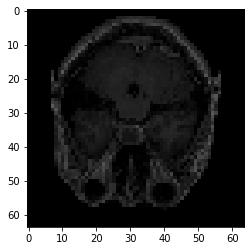

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pituitary_tumor 


VALIDATION:
torch.Size([32, 3, 64, 64])
32


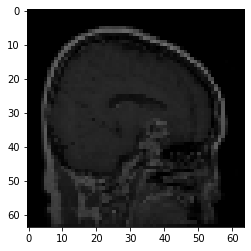

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pituitary_tumor 


TESTING:
torch.Size([32, 3, 64, 64])
32


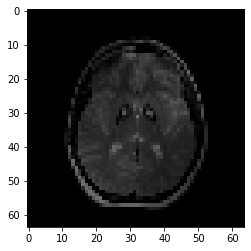

no_tumor


In [ ]:
print("TRAINING:")
trimages, trlabels = next(iter(trainloader))
print(trimages.shape)
print(len(trlabels))
trimages = trimages.permute(0,2,3,1)
plt.imshow(trimages[0])
plt.show()
print(categories[(trlabels[0])], "\n")

print("\n" + "VALIDATION:")
vimages, vlabels = next(iter(validationloader))
print(vimages.shape)
print(len(vlabels))
vimages = vimages.permute(0,2,3,1)
plt.imshow(vimages[0])
plt.show()
print(categories[(vlabels[0])], "\n")

print("\n" + "TESTING:")
teimages, telabels = next(iter(testingloader))
print(teimages.shape)
print(len(telabels))
teimages = teimages.permute(0,2,3,1)
plt.imshow(teimages[0])
plt.show()
print(categories[(telabels[0])])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

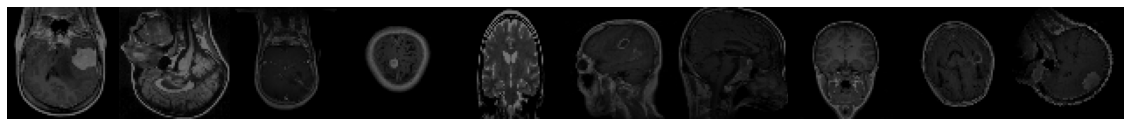

meningioma_tumor|no_tumor|glioma_tumor|meningioma_tumor|no_tumor|glioma_tumor|pituitary_tumor|no_tumor|glioma_tumor|meningioma_tumor|

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# visualize the images
nrows=4
ncols=10
images, labels = next(iter(trainloader))
images = images.permute((0,2,3,1))

plt.figure(figsize=(20, 20))
for i in range(len(images[:10])):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(images[i])
  plt.axis('off')
  plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

plt.figure(figsize=(20, 20))
for j in labels[:10]:
  print(categories[j], end="|")

In [527]:
from torch.nn.modules.linear import Linear
from torch.nn.modules.batchnorm import BatchNorm2d
from torch import nn

# model
# Using batch normalization makes the network more stable during training. 
# This may require the use of much larger than normal learning rates, that in turn may further speed up the learning process.

model = nn.Sequential(
    # 64 x 64 x 3
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    # 64 x 64 x 16
    nn.MaxPool2d(2,2),
    # 32 x 32 x 16
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    # 32 x 32 x 32
    nn.MaxPool2d(2,2),
    # 16 x 16 x 32
    # flatten
    nn.Flatten(),
    # 1 x 16384
    nn.Linear(16*16*32, 512),
    nn.ReLU(),
    nn.Dropout(p=0.7),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(p=0.6),
    nn.Linear(256,4), # end output = number of classes
    nn.Softmax(dim=1)) # for matrices, dim=1

In [528]:
print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=8192, out_features=512, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.7, inplace=False)
  (12): Linear(in_features=512, out_features=256, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.6, inplace=False)
  (15): Linear(in_features=256, out_features=4, bias=True)
  (16): Softmax(dim=1)
)


In [529]:
# to check if the model works
inp = torch.rand(1,3,64,64)
print(inp.shape)

out = model(inp)
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 4])


In [ ]:
from torch import optim
import datetime

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# training

ttraining_losses = []
tvalidation_losses = []

epochs = 30

for epoch in range(epochs):
  start_epoch = datetime.datetime.now()
  training_loss = 0
  validation_loss = 0
  model.train()
  for images, labels in trainloader: # each batch at a time
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    training_loss += loss.item() # loss.item() contains the loss of entire mini-batch, but divided by the batch size

  model.eval()

  for images, labels in validationloader: # each batch at a time
    images, labels = next(iter(validationloader))
    outputs = model(images)
    loss = criterion(outputs, labels)

    validation_loss += loss.item()

  mean_trloss = training_loss/len(trainloader) # total loss from "every batch/number of batches"
  mean_vloss = validation_loss/len(validationloader)

  ttraining_losses.append(mean_trloss)
  tvalidation_losses.append(mean_vloss)

  print("Epoch: {}  |  Training Loss: {:.4f}  |  Validation Loss: {:.4f}  |".format(epoch+1, mean_trloss, mean_vloss))

  if mean_vloss <= min(tvalidation_losses):
    print("Validation Loss has decreased - saving model...")
    torch.save(model.state_dict(), "braintumorclassification.pth")

  end_epoch = datetime.datetime.now()
  print("Epoch time:", str(end_epoch-start_epoch) + "\n")

Epoch: 1  |  Training Loss: 1.0041  |  Validation Loss: 1.0235  |
Validation Loss has decreased - saving model...
Epoch time: 0:00:10.516138

Epoch: 2  |  Training Loss: 0.9812  |  Validation Loss: 1.0174  |
Validation Loss has decreased - saving model...
Epoch time: 0:00:10.587854

Epoch: 3  |  Training Loss: 0.9610  |  Validation Loss: 1.0396  |
Epoch time: 0:00:10.575063

Epoch: 4  |  Training Loss: 0.9335  |  Validation Loss: 1.0015  |
Validation Loss has decreased - saving model...
Epoch time: 0:00:10.728524

Epoch: 5  |  Training Loss: 0.9219  |  Validation Loss: 0.9944  |
Validation Loss has decreased - saving model...
Epoch time: 0:00:10.503949

Epoch: 6  |  Training Loss: 0.9068  |  Validation Loss: 0.9905  |
Validation Loss has decreased - saving model...
Epoch time: 0:00:10.401911

Epoch: 7  |  Training Loss: 0.8850  |  Validation Loss: 0.9620  |
Validation Loss has decreased - saving model...
Epoch time: 0:00:10.744782

Epoch: 8  |  Training Loss: 0.8705  |  Validation Loss

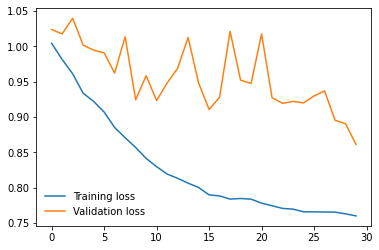

In [ ]:
plt.plot(ttraining_losses, label="Training loss")
plt.plot(tvalidation_losses, label="Validation loss")
plt.legend(frameon=False)

In [ ]:
loaded_model = torch.load("braintumorclassification.pth")
model.load_state_dict(loaded_model)

<All keys matched successfully>

In [ ]:
import numpy as np

# testing
test_correct = [0,0,0,0]
test_total = [0,0,0,0]
ttesting_loss = 0

for images, labels in testingloader: # each batch at a time
  torch.no_grad() # disabled gradient calculation
  outputs = model(images)
  testing_loss = criterion(outputs, labels)

  ttesting_loss += testing_loss.item()

  probabilities = torch.exp(outputs) # output is the log probablities, so we use torch.exp to take the exponential (get the actual probabilites)
  top_probabilities, top_categories = probabilities.topk(1, dim=1)

  for i in range(32): # from each batch
    label = labels.data[i] # what label are we looking at
    pred = top_categories[i]
    if label == pred:
      test_correct[label] += 1
    test_total[label] += 1

print("Testing Loss", str(testing_loss/len(testingloader)), "\n")

gt_acc = (test_correct[0]/test_total[0])*100
mt_acc = (test_correct[1]/test_total[1])*100
nt_acc = (test_correct[2]/test_total[2])*100
pt_acc = (test_correct[3]/test_total[3])*100

accuracy = (gt_acc + mt_acc + nt_acc + pt_acc)/4

print("Overall Accuracy: {:.2f}%".format(accuracy))
print("Accuracy of Glioma Tumour: {:.2f}%".format(gt_acc))
print("Accuracy of Meningioma Tumour: {:.2f}%".format(mt_acc))
print("Accuracy of No Tumour: {:.2f}%".format(nt_acc))
print("Accuracy of Pituitary Tumour: {:.2f}%".format(pt_acc))

Testing Loss tensor(0.1012, grad_fn=<DivBackward0>) 

Overall Accuracy: 51.21%
Accuracy of Glioma Tumour: 16.00%
Accuracy of Meningioma Tumour: 68.70%
Accuracy of No Tumour: 90.48%
Accuracy of Pituitary Tumour: 29.69%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicition: meningioma_tumor 
Label: meningioma_tumor


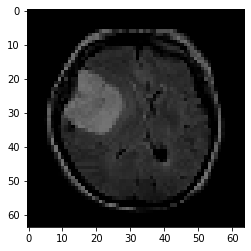



Predicition: no_tumor 
Label: no_tumor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


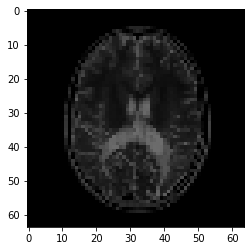

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicition: meningioma_tumor 
Label: glioma_tumor


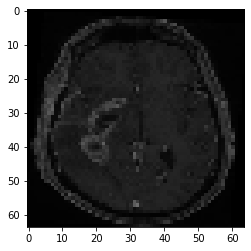

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicition: glioma_tumor 
Label: glioma_tumor


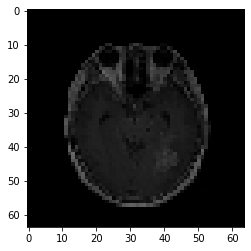

In [564]:
# visualize the images
nrows=4
ncols=10

visual_images, visual_labels = next(iter(testingloader))

visual_images = visual_images[:4]
visual_labels = visual_labels[:4]

for i in range(len(visual_images)):
  image = visual_images[i]
  label = visual_labels[i]
  image = image.unsqueeze(1)
  image = image.permute(1,0,2,3)
  output = model(image)
  probabilities = torch.exp(output)
  top_probabilities, top_categories = probabilities.topk(1, dim=1)
  print("Predicition:", categories[top_categories] + " \n" +
        "Label:", categories[label])
  image = image.squeeze()
  image = image.permute(1,2,0)
  plt.imshow(image)
  plt.show()
  print("\n")